Using device: cpu
Loading image paths from 33 classes...
Class 'ya': 780 images
Class 'yab': 780 images
Class 'yach': 780 images
Class 'yad': 780 images
Class 'yadd': 780 images
Class 'yae': 780 images
Class 'yaf': 780 images
Class 'yag': 780 images
Class 'yagh': 780 images
Class 'yagw': 780 images
Class 'yah': 780 images
Class 'yahh': 780 images
Class 'yaj': 780 images
Class 'yak': 780 images
Class 'yakw': 780 images
Class 'yal': 780 images
Class 'yam': 780 images
Class 'yan': 780 images
Class 'yaq': 780 images
Class 'yar': 780 images
Class 'yarr': 780 images
Class 'yas': 780 images
Class 'yass': 780 images
Class 'yat': 780 images
Class 'yatt': 780 images
Class 'yaw': 780 images
Class 'yax': 780 images
Class 'yay': 780 images
Class 'yaz': 780 images
Class 'yazz': 780 images
Class 'yey': 780 images
Class 'yi': 780 images
Class 'yu': 780 images
Total images loaded: 25740
Number of classes: 33
Classes: ['ya', 'yab', 'yach', 'yad', 'yadd', 'yae', 'yaf', 'yag', 'yagh', 'yagw', 'yah', 'yahh

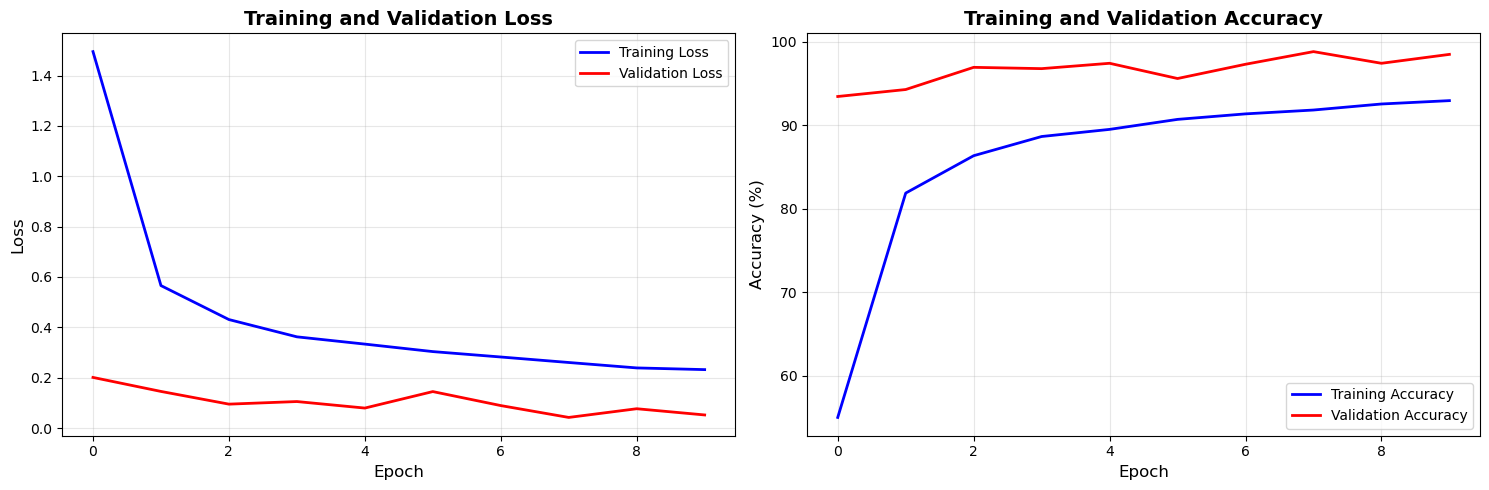


Generating confusion matrix...


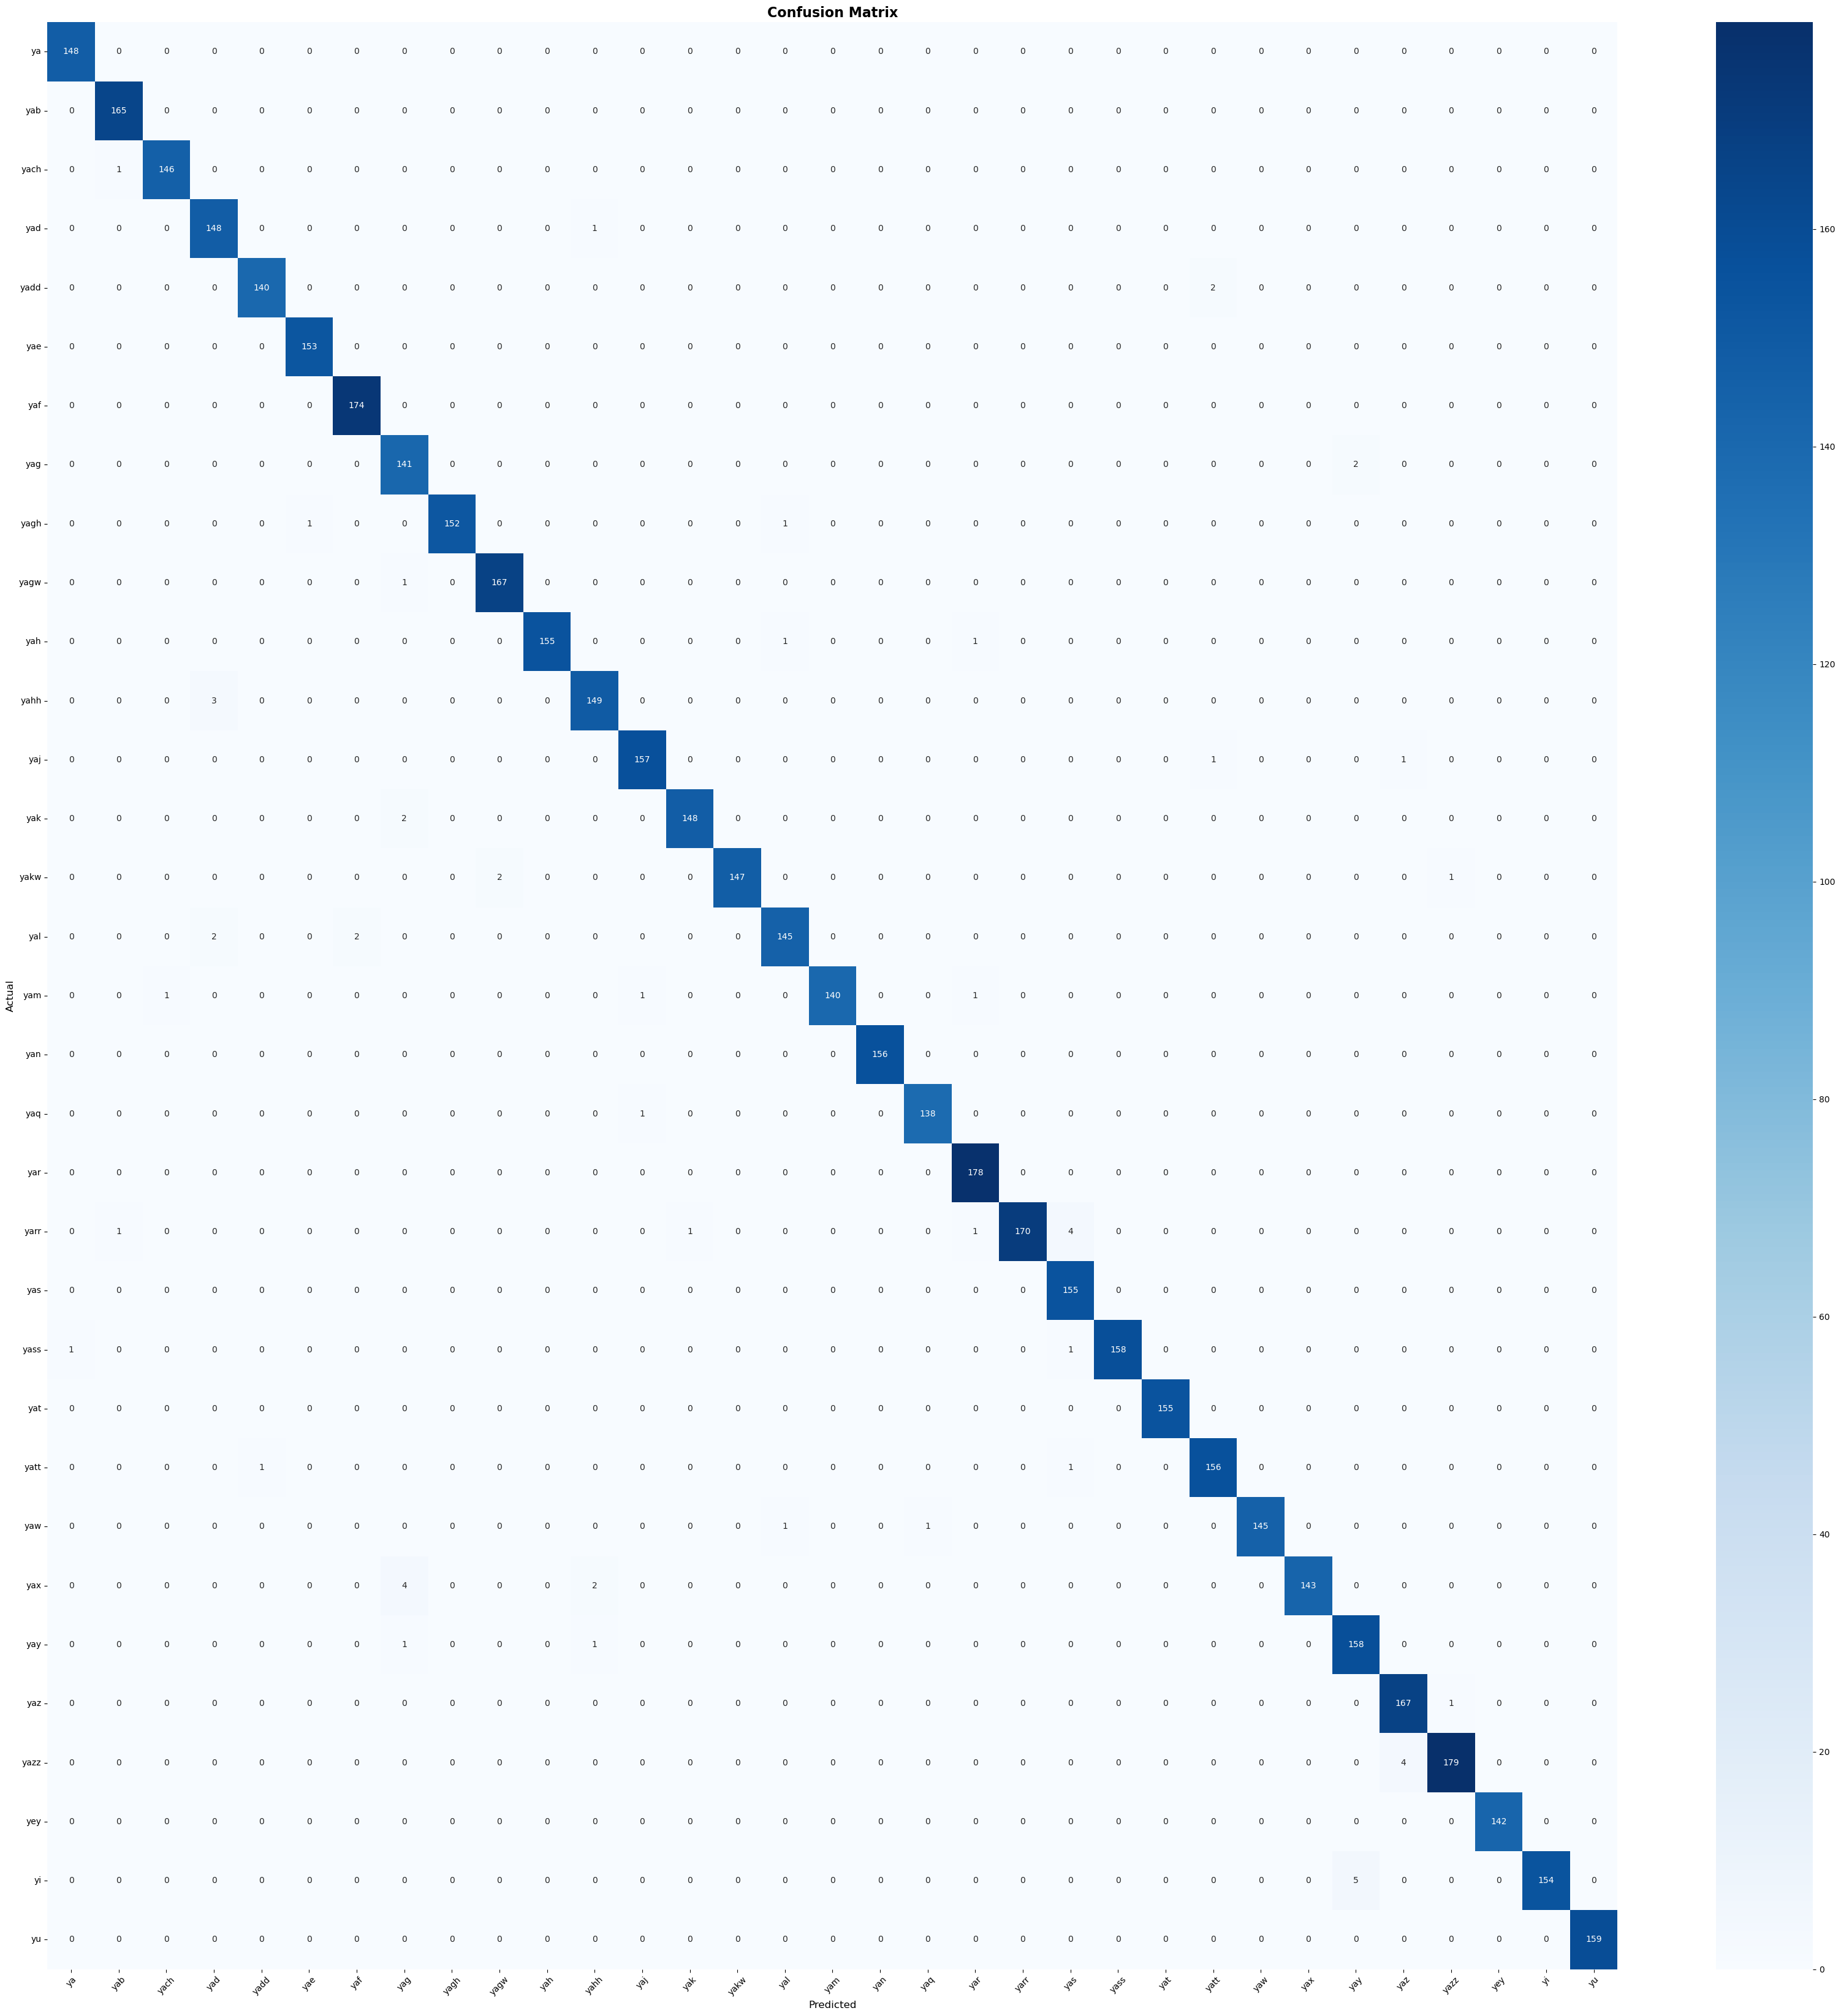

CLASSIFICATION REPORT
              precision    recall  f1-score   support

          ya       0.99      1.00      1.00       148
         yab       0.99      1.00      0.99       165
        yach       0.99      0.99      0.99       147
         yad       0.97      0.99      0.98       149
        yadd       0.99      0.99      0.99       142
         yae       0.99      1.00      1.00       153
         yaf       0.99      1.00      0.99       174
         yag       0.95      0.99      0.97       143
        yagh       1.00      0.99      0.99       154
        yagw       0.99      0.99      0.99       168
         yah       1.00      0.99      0.99       157
        yahh       0.97      0.98      0.98       152
         yaj       0.99      0.99      0.99       159
         yak       0.99      0.99      0.99       150
        yakw       1.00      0.98      0.99       150
         yal       0.98      0.97      0.98       149
         yam       1.00      0.98      0.99       143
     

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import pandas as pd
import os
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import cv2

class AMHCDDatasetRGB(Dataset):
    def __init__(self, data_path, transform=None, image_size=(64, 64)):
        """
        Dataset class for loading images from directory structure.
        
        Args:
            data_path (str): Path to the root directory containing class subdirectories
            transform: PyTorch transforms to apply
            image_size (tuple): Target size for resizing images (height, width)
        """
        self.data_path = data_path
        self.transform = transform
        self.image_size = image_size
        
        # Get sorted list of class directories
        self.classes = sorted([d for d in os.listdir(data_path) 
                              if os.path.isdir(os.path.join(data_path, d))])
        
        if not self.classes:
            raise ValueError(f"No classes found in directory '{data_path}'.")
        
        # Create label mappings
        self.label_map = {label: idx for idx, label in enumerate(self.classes)}
        self.idx_to_label = {idx: label for label, idx in self.label_map.items()}
        
        # Load all image paths and labels
        self.image_paths = []
        self.labels = []
        
        print(f"Loading image paths from {len(self.classes)} classes...")
        for label in self.classes:
            class_dir = os.path.join(data_path, label)
            class_images = [f for f in os.listdir(class_dir) 
                           if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
            
            for img_file in class_images:
                img_path = os.path.join(class_dir, img_file)
                self.image_paths.append(img_path)
                self.labels.append(self.label_map[label])
            
            print(f"Class '{label}': {len(class_images)} images")
        
        print(f"Total images loaded: {len(self.image_paths)}")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        try:
            # Load image using PIL for better compatibility with transforms
            image = Image.open(img_path).convert('RGB')
            
            if self.transform:
                image = self.transform(image)
            else:
                # Default preprocessing if no transform
                image = image.resize(self.image_size)
                image = transforms.ToTensor()(image)
                
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image as fallback
            image = torch.zeros(3, self.image_size[0], self.image_size[1])
        
        return image, label

class TifinaghCNNRGB(nn.Module):
    def __init__(self, num_classes, input_size=64):
        super().__init__()
        self.conv_layers = nn.Sequential(
            # First conv block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # RGB input: 3 channels
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64x64 -> 32x32
            
            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32x32 -> 16x16
            
            # Third conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16 -> 8x8
            
            # Fourth conv block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 8x8 -> 4x4
        )
        
        # Calculate the size after conv layers
        final_size = input_size // (2**4)  # 4 max pool layers
        fc_input_size = 256 * final_size * final_size
        
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(fc_input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

# Define transforms for RGB images
def get_transforms(image_size=(64, 64)):
    train_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

# Training function
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Print progress every 50 batches
        if batch_idx % 50 == 0:
            print(f'Batch [{batch_idx}/{len(dataloader)}], Loss: {loss.item():.4f}')
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc, all_predictions, all_labels

# Plot training curves
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss curve
    ax1.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
    ax1.plot(val_losses, label='Validation Loss', color='red', linewidth=2)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy curve
    ax2.plot(train_accuracies, label='Training Accuracy', color='blue', linewidth=2)
    ax2.plot(val_accuracies, label='Validation Accuracy', color='red', linewidth=2)
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(max(12, len(class_names)), max(10, len(class_names))))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return cm

# Generate evaluation report
def generate_evaluation_report(y_true, y_pred, class_names):
    # Classification report
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    
    print("=" * 60)
    print("CLASSIFICATION REPORT")
    print("=" * 60)
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Overall metrics
    accuracy = report['accuracy']
    macro_avg = report['macro avg']
    weighted_avg = report['weighted avg']
    
    print("=" * 60)
    print("SUMMARY METRICS")
    print("=" * 60)
    print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Macro Average Precision: {macro_avg['precision']:.4f}")
    print(f"Macro Average Recall: {macro_avg['recall']:.4f}")
    print(f"Macro Average F1-Score: {macro_avg['f1-score']:.4f}")
    print(f"Weighted Average Precision: {weighted_avg['precision']:.4f}")
    print(f"Weighted Average Recall: {weighted_avg['recall']:.4f}")
    print(f"Weighted Average F1-Score: {weighted_avg['f1-score']:.4f}")
    
    # Per-class accuracy
    print("\n" + "=" * 60)
    print("PER-CLASS ACCURACY")
    print("=" * 60)
    for i, class_name in enumerate(class_names):
        if class_name in report:
            class_accuracy = report[class_name]['precision']
            support = report[class_name]['support']
            print(f"{class_name}: {class_accuracy:.4f} ({class_accuracy*100:.2f}%) - {support} samples")
    
    return report

class TransformDataset(Dataset):
    """Dataset wrapper that applies transforms to a subset of the original dataset"""
    def __init__(self, dataset, indices, transform):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
        
    def __len__(self):
        return len(self.indices)
        
    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        img_path = self.dataset.image_paths[actual_idx]
        label = self.dataset.labels[actual_idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
            
            if self.transform:
                image = self.transform(image)
            else:
                image = transforms.Compose([
                    transforms.Resize(self.dataset.image_size),
                    transforms.ToTensor()
                ])(image)
                
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image as fallback
            image = torch.zeros(3, self.dataset.image_size[0], self.dataset.image_size[1])
            
        return image, label

def main():
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
    
    # Get transforms
    train_transform, val_transform = get_transforms(image_size=(64, 64))
    
    # Create dataset from directory structure
    data_path = './archive/AMHCD_64/AMHCD_64'  # Update this path as needed
    
    # Create full dataset
    full_dataset = AMHCDDatasetRGB(
        data_path=data_path,
        transform=None,  # We'll apply transforms separately
        image_size=(64, 64)
    )
    
    # Split dataset into train and validation indices
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_indices, val_indices = torch.utils.data.random_split(
        range(len(full_dataset)), [train_size, val_size], 
        generator=torch.Generator().manual_seed(42)
    )
    
    # Create separate datasets with different transforms
    train_dataset = TransformDataset(full_dataset, train_indices.indices, train_transform)
    val_dataset = TransformDataset(full_dataset, val_indices.indices, val_transform)
    
    # Create DataLoaders (set num_workers=0 to avoid multiprocessing issues)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
    
    # Number of classes
    num_classes = len(full_dataset.classes)
    print(f"Number of classes: {num_classes}")
    print(f"Classes: {full_dataset.classes}")
    print(f"Training samples: {train_size}, Validation samples: {val_size}")
    
    # Initialize model
    model = TifinaghCNNRGB(num_classes=num_classes, input_size=64)
    model = model.to(device)
    
    # Print model info
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nModel Architecture:")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    # Training loop with tracking
    num_epochs = 10
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    best_val_acc = 0.0
    patience = 7
    patience_counter = 0
    
    print("\nStarting training...")
    print("=" * 60)
    
    for epoch in range(num_epochs):
        print(f'\nEpoch [{epoch+1}/{num_epochs}]')
        
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_loss, val_acc, val_predictions, val_labels = validate_epoch(model, val_loader, criterion, device)
        
        # Update learning rate
        scheduler.step()
        
        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        # Save best model and early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'label_map': full_dataset.label_map,
                'idx_to_label': full_dataset.idx_to_label,
                'classes': full_dataset.classes
            }, 'best_tifinagh_rgb_cnn_model.pth')
            print(f"✓ New best model saved! Val Acc: {val_acc:.2f}%")
        else:
            patience_counter += 1
        
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
        
        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {patience} epochs without improvement")
            break
        
        print('-' * 50)
    
    # Final evaluation on validation set
    print("\n" + "="*60)
    print("FINAL EVALUATION")
    print("="*60)
    
    # Load best model
    checkpoint = torch.load('best_tifinagh_rgb_cnn_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
    
    # Get final predictions
    model.eval()
    final_predictions = []
    final_labels = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            final_predictions.extend(predicted.cpu().numpy())
            final_labels.extend(labels.cpu().numpy())
    
    # Get class names
    class_names = full_dataset.classes
    
    # Plot training curves
    print("\nGenerating training curves...")
    plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)
    
    # Plot confusion matrix
    print("\nGenerating confusion matrix...")
    cm = plot_confusion_matrix(final_labels, final_predictions, class_names)
    
    # Generate evaluation report
    report = generate_evaluation_report(final_labels, final_predictions, class_names)
    
    # Save final model and training history
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'label_map': full_dataset.label_map,
        'idx_to_label': full_dataset.idx_to_label,
        'classes': full_dataset.classes,
        'num_classes': num_classes,
        'best_val_acc': best_val_acc
    }, 'tifinagh_rgb_cnn_final_model.pth')
    
    print(f"\nModels and training history saved:")
    print(f"- Best model: 'best_tifinagh_rgb_cnn_model.pth'")
    print(f"- Final model: 'tifinagh_rgb_cnn_final_model.pth'")
    print(f"Best validation accuracy: {best_val_acc:.2f}%")
    print(f"Final validation accuracy: {val_accuracies[-1]:.2f}%")
    
    # Show class distribution
    print(f"\nClass distribution in validation set:")
    unique, counts = np.unique(final_labels, return_counts=True)
    for idx, count in zip(unique, counts):
        print(f"{class_names[idx]}: {count} samples")

if __name__ == "__main__":
    main()